# Compare peptigate outputs against nORF peptide predictions

This notebook compares peptigate peptide predictions against those with ribosome profiling or mass spec support as reported in the database nORF.

In [2]:
library(tidyverse)
library(ggExtra)
library(arcadiathemeR)

In [3]:
peptigate <- read_tsv("../../peptigate/results/predictions/peptide_predictions.tsv.gz", show_col_types = FALSE) %>%
  rename_with(~paste0("peptigate_", .))
     

peptigate_distinct <- peptigate %>%
 select(peptigate_prediction_tool, peptigate_protein_sequence) %>%
 distinct()

nrow(peptigate_distinct)

peptigate_summary <- peptigate_distinct %>% 
  group_by(peptigate_prediction_tool) %>% 
  tally()
peptigate_summary

[1] 4235

peptigate_prediction_tool,n
<chr>,<int>
deeppeptide,1549
nlpprecursor,431
plmutils,2255


In [5]:
norf <- read_tsv("nORFsDB.1.1_full.tsv", show_col_types = FALSE) %>%
  rename_with(~paste0("norf_", .)) %>%
  filter(norf_sorf_length < 101) 
head(norf)
nrow(norf)

norf_novel_orf_id,norf_transcript_id,norf_transcript_biotype,norf_orf_annotation,norf_in_frame,norf_coding_region,norf_seqname,norf_source,norf_feature,norf_start,norf_end,norf_score,norf_strand,norf_frame,norf_AA_seq,norf_start_codon,norf_sorf_length
<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
001aH1,ENST00000457540,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,629922,629981,.,+,.,MLIIIMAIAIKLGIAPFHF,CTG,20
001bH1,ENST00000457540,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,630009,630038,.,+,.,MTSGLLLLT,CTG,10
002kH1,ENST00000414273,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,631379,631582,.,+,.,MTLTPLSPTPACICYSGGRRRNRLNSLPSLGRELLPPWSLRRPNHLLLTPSRYLLYLRSHQFHHNNY,CTG,68
002kH2,ENST00000414273,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,631407,631451,.,+,.,MLASAIVEAGAGTG,CTG,15
002nH2,ENST00000414273,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,632305,632424,.,+,.,MIHFAIIFIGVNLTFFPQHFLGLSGMPRRYSDYPDAYTT,TTG,40
002vH1,ENST00000514057,unprocessed_pseudogene,pseudogene,FALSE,FALSE,1,sorfs.org,gene,634019,634054,.,+,.,MSGRSDYRLSL,ATG,12


[1] 228906

In [6]:
# what types of ORFs are in nORF db?
norf %>% group_by(norf_orf_annotation) %>% tally() %>% arrange(desc(n))

norf_orf_annotation,n
<chr>,<int>
cds,107028
cds-intronic,52426
utr5,15165
retained_intron,11568
ncRNA,8917
utr5-cds,6769
utr5-intronic,5998
utr3,5060
intergenic,4116


## Do peptigate and nORF db detect some of the same peptide sequences?

In [9]:
blastp <- read_tsv("peptigate_sequences_vs_norf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend",
                                 "sstart", "send", "qcovhsp", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct()

In [10]:
nrow(blastp)

[1] 6086

In [11]:
blastp <- blastp %>%
  # join with peptigate results to get prediction tool
  left_join(peptigate, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(norf, by = c("sseqid" = "norf_novel_orf_id"))

In [12]:
head(blastp)

qseqid,qlen,qseq,sseqid,slen,sseq,pident,length,mismatch,gapopen,⋯,norf_source,norf_feature,norf_start,norf_end,norf_score,norf_strand,norf_frame,norf_AA_seq,norf_start_codon,norf_sorf_length
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
NM_000015.3.p1_start1_end19,19,LYYRPWKQEDCIQPSSWL,bqcgH3,26,LPHRPWMWEDCIQSSSWL,72.222,18,5,0,⋯,sorfs.org,gene,18210101,18219411,.,+,.,MRALPHRPWMWEDCIQSSSWLPAEIT,GTG,27
NM_000043.6.p1_start26_end45,20,QVTDINSKGLELRKTVTTVE,d4gvH8,70,QVTDINSKGLELRKTVTTVE,100.000,20,0,0,⋯,sorfs.org,gene,89003029,89003241,.,+,.,MLTSVARLSSKSVNAQVTDINSKGLELRKTVTTVETQNLEGLHHDGQFCHKPCPPGMLHKTSRDYSESHS,GTT,71
NM_000057.4.p3_start61_end116,55,SLLSSWDYRRACTPRLANFCIFSRDGVSPCWAGWSQTPDLVIHLPRPPKVLGSQA,glvfH1,144,SLLSSWDYRH-MPPRPANFCIFSRDWVSPCWSGWSQTPDLVIHPPRPPKILGLQA,81.818,55,9,1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NM_000131.4.p1_start1_end26,26,MPWKPGPHRVFVTQEEAHGVLHRRRR,duu7H3,29,MPCQPGHHRLFAFKEWEWQCYHHRGR,42.308,26,15,0,⋯,sorfs.org,gene,75797162,75797251,.,+,.,MPCQPGHHRLFAFKEWEWQCYHHRGRGCG,CTG,30
NM_000133.4.p1_start24_end41,18,TVFLDHENANKILNRPK,b6lzH2,55,TLFLNHWRTEALLRKPK,41.176,17,10,0,⋯,openprot.org,gene,94666086,94666253,.,+,.,MLISLWRGRRGGGGHDFSCGFGTLFLNHWRTEALLRKPKLSVQCGKASVILSLHP,ATG,55
NM_000159.4.p1_start23_end45,23,WVSSAAQTEKGGRTQSQLAKSSR,0r24H1,212,WTDGVGEGRKGGRKEGILAPSLR,39.130,23,14,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [13]:
# filter to distinct sequences (not guaranteed distinct after join)
blastp_distinct <- blastp %>%
  select(-qseqid, -sseqid) %>%
  distinct()

# filter to sORF sequences
blastp_distinct_sorf <- blastp_distinct %>%
  filter(peptigate_prediction_tool == "plmutils")

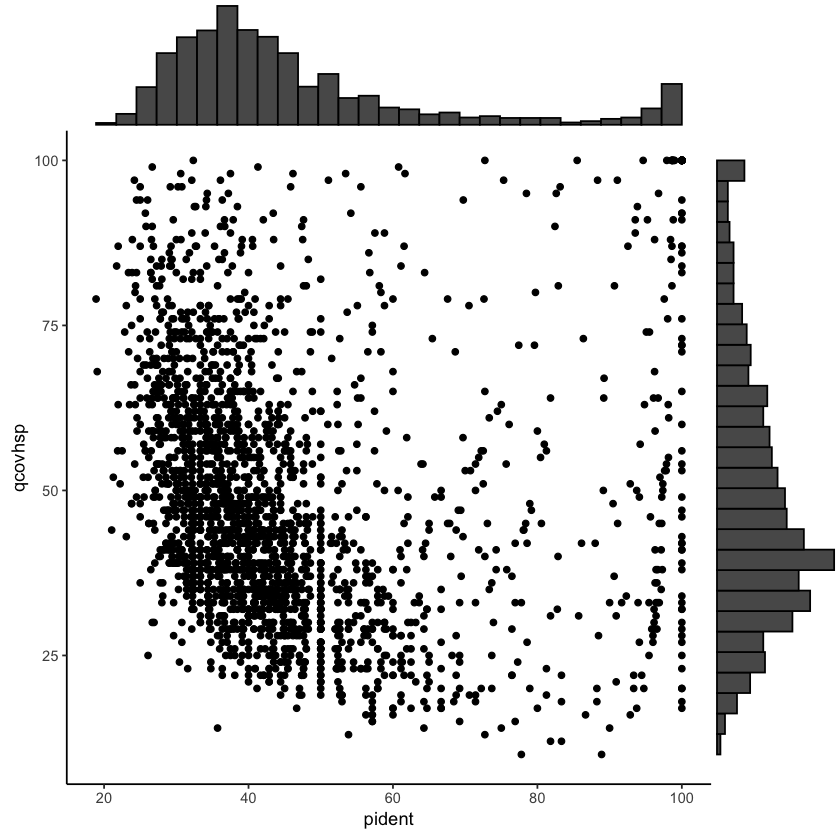

In [14]:
plt1 <- ggplot(blastp_distinct_sorf, aes(x = pident, y = qcovhsp)) +
  geom_point() +
  theme_classic() +
  theme(legend.position = "bottom")

ggMarginal(plt1, type = "histogram")

In [26]:
blastp_strong <- blastp_distinct %>% 
  filter(pident > 90) 
norf_vs_peptigate_summary <- blastp_strong  %>%
  group_by(peptigate_prediction_tool, norf_orf_annotation) %>%
  summarize(num = n(), 
            mean_pident = mean(pident),
            mean_length = mean(length),
            mean_qcovhsp = mean(qcovhsp)) %>%
  arrange(desc(num)) %>%
  filter(peptigate_prediction_tool == "plmutils")

norf_vs_peptigate_summary
sum(norf_vs_peptigate_summary$num)

`summarise()` has grouped output by 'peptigate_prediction_tool'. You can override using the `.groups` argument.


peptigate_prediction_tool,norf_orf_annotation,num,mean_pident,mean_length,mean_qcovhsp
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
plmutils,cds,28,98.51554,43.67857,58.60714
plmutils,ncRNA,28,97.62279,46.89286,64.03571
plmutils,cds-intronic,18,96.34256,33.44444,42.66667
plmutils,antisense,17,98.07082,46.58824,68.00000
plmutils,pseudogene,12,94.94242,55.41667,76.33333
plmutils,retained_intron,9,96.49800,33.66667,42.00000
plmutils,utr5-cds,8,98.49312,58.62500,78.00000
plmutils,NA,7,97.89657,62.00000,84.42857
plmutils,utr5,5,100.00000,55.00000,86.00000


[1] 149

# how many total

In [21]:
riborf <- read_tsv("../riborf/riborf_human.bed", show_col_types = FALSE,
                   col_names = c("chromosome", "start", "end", "name", 
                                 "score", "strand", "thickStart", "thickEnd",
                                 "itemRgb", "blockCount", "blockSizes", "blockStarts", 
                                 "transcriptInfo")) %>%
  separate(name, into = c("transcript_name", "num_exons", "loc_info", "type", "start_codon"), sep = "\\|", remove = FALSE) %>%
  separate(loc_info, into = c("length", "relative_start", "relative_end"), sep = ":") %>%
  mutate(translated_length = (as.numeric(relative_end) - as.numeric(relative_start)) / 3) %>%
  rename_with(~paste0("riborf_", .))

In [24]:
peptigate_annotations_distinct <- read_tsv("../../peptigate/results/predictions/peptide_annotations.tsv.gz", show_col_types = F) %>%
  mutate(peptigate_peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit")) %>%
  select(peptigate_peptide_id = peptide_id, peptigate_peptipedia_blast_result) %>%
  left_join(peptigate, by = "peptigate_peptide_id") %>%
  group_by(peptigate_protein_sequence) %>%
  slice_head(n = 1) %>%
  ungroup()
     

blastp2 <- read_tsv("../riborf/peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend", "sstart", "send",
                                 "qcovhsp", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct() %>%
  # join with peptigate results to get prediction tool
  right_join(peptigate_annotations_distinct, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(riborf, by = c("sseqid" = "riborf_name")) %>%
  # remove unwanted columns from riborf join, only keep riborf_type, riborf_start_codon,
  select(-riborf_chromosome, -riborf_start, -riborf_end,
         -riborf_transcript_name, -riborf_num_exons, -riborf_length, 
         -riborf_relative_start, -riborf_relative_end, 
         -riborf_start_codon, -riborf_score, -riborf_strand, -riborf_thickStart, 
         -riborf_thickEnd, -riborf_itemRgb, -riborf_blockCount, -riborf_blockSizes, 
         -riborf_blockStarts, -riborf_translated_length) %>%
  mutate(riborf_blast_result = ifelse(!is.na(riborf_type), "blast hit", "no blast hit"),
         riborf_blast_result_strong = ifelse(pident >= 90, "blast hit", "no blast hit"))

In [32]:
blastp <- read_tsv("peptigate_sequences_vs_norf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend",
                                 "sstart", "send", "qcovhsp", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct() %>%
  # join with peptigate results to get prediction tool
  left_join(peptigate, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(norf, by = c("sseqid" = "norf_novel_orf_id")) %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  mutate(norf_blast_result_strong = ifelse(pident >= 90, "blast hit", "no blast hit"))

In [33]:
colnames(blastp2)
colnames(blastp)

[1] "qseqid"                              
 [2] "qlen"                                
 [3] "qseq"                                
 [4] "sseqid"                              
 [5] "slen"                                
 [6] "sseq"                                
 [7] "pident"                              
 [8] "length"                              
 [9] "mismatch"                            
[10] "gapopen"                             
[11] "qstart"                              
[12] "qend"                                
[13] "sstart"                              
[14] "send"                                
[15] "qcovhsp"                             
[16] "evalue"                              
[17] "bitscore"                            
[18] "peptigate_peptipedia_blast_result"   
[19] "peptigate_peptide_type"              
[20] "peptigate_prediction_tool"           
[21] "peptigate_plmutils_class_probability"
[22] "peptigate_protein_sequence"          
[23] "riborf_type"                         
[24] "riborf_blast_result"                 
[25] "riborf_blast_result_strong"

[1] "qseqid"                              
 [2] "qlen"                                
 [3] "qseq"                                
 [4] "sseqid"                              
 [5] "slen"                                
 [6] "sseq"                                
 [7] "pident"                              
 [8] "length"                              
 [9] "mismatch"                            
[10] "gapopen"                             
[11] "qstart"                              
[12] "qend"                                
[13] "sstart"                              
[14] "send"                                
[15] "qcovhsp"                             
[16] "evalue"                              
[17] "bitscore"                            
[18] "peptigate_peptide_type"              
[19] "peptigate_prediction_tool"           
[20] "peptigate_plmutils_class_probability"
[21] "peptigate_protein_sequence"          
[22] "norf_transcript_id"                  
[23] "norf_transcript_biotype"             
[24] "norf_orf_annotation"                 
[25] "norf_in_frame"                       
[26] "norf_coding_region"                  
[27] "norf_seqname"                        
[28] "norf_source"                         
[29] "norf_feature"                        
[30] "norf_start"                          
[31] "norf_end"                            
[32] "norf_score"                          
[33] "norf_strand"                         
[34] "norf_frame"                          
[35] "norf_AA_seq"                         
[36] "norf_start_codon"                    
[37] "norf_sorf_length"                    
[38] "norf_blast_result_strong"

In [38]:
blastp3 <- blastp2 %>%
 left_join(blastp, by = c("qseqid", "peptigate_prediction_tool")) 

In [39]:
colnames(blastp3)

[1] "qseqid"                                
 [2] "qlen.x"                                
 [3] "qseq.x"                                
 [4] "sseqid.x"                              
 [5] "slen.x"                                
 [6] "sseq.x"                                
 [7] "pident.x"                              
 [8] "length.x"                              
 [9] "mismatch.x"                            
[10] "gapopen.x"                             
[11] "qstart.x"                              
[12] "qend.x"                                
[13] "sstart.x"                              
[14] "send.x"                                
[15] "qcovhsp.x"                             
[16] "evalue.x"                              
[17] "bitscore.x"                            
[18] "peptigate_peptipedia_blast_result"     
[19] "peptigate_peptide_type.x"              
[20] "peptigate_prediction_tool"             
[21] "peptigate_plmutils_class_probability.x"
[22] "peptigate_protein_sequence.x"          
[23] "riborf_type"                           
[24] "riborf_blast_result"                   
[25] "riborf_blast_result_strong"            
[26] "qlen.y"                                
[27] "qseq.y"                                
[28] "sseqid.y"                              
[29] "slen.y"                                
[30] "sseq.y"                                
[31] "pident.y"                              
[32] "length.y"                              
[33] "mismatch.y"                            
[34] "gapopen.y"                             
[35] "qstart.y"                              
[36] "qend.y"                                
[37] "sstart.y"                              
[38] "send.y"                                
[39] "qcovhsp.y"                             
[40] "evalue.y"                              
[41] "bitscore.y"                            
[42] "peptigate_peptide_type.y"              
[43] "peptigate_plmutils_class_probability.y"
[44] "peptigate_protein_sequence.y"          
[45] "norf_transcript_id"                    
[46] "norf_transcript_biotype"               
[47] "norf_orf_annotation"                   
[48] "norf_in_frame"                         
[49] "norf_coding_region"                    
[50] "norf_seqname"                          
[51] "norf_source"                           
[52] "norf_feature"                          
[53] "norf_start"                            
[54] "norf_end"                              
[55] "norf_score"                            
[56] "norf_strand"                           
[57] "norf_frame"                            
[58] "norf_AA_seq"                           
[59] "norf_start_codon"                      
[60] "norf_sorf_length"                      
[61] "norf_blast_result_strong"

In [40]:
blastp3 %>%
  mutate(evidence_peptide_is_real = ifelse(peptigate_peptipedia_blast_result == "blast hit" | riborf_blast_result_strong == "blast hit" | norf_blast_result_strong == "blast hit",
                                           "evidence",
                                           "no evidence"),
        evidence_peptide_is_real = ifelse(is.na(evidence_peptide_is_real), "no evidence", evidence_peptide_is_real)) %>%
  group_by(peptigate_prediction_tool, evidence_peptide_is_real) %>%
  tally()

peptigate_prediction_tool,evidence_peptide_is_real,n
<chr>,<chr>,<int>
deeppeptide,evidence,1094
deeppeptide,no evidence,455
nlpprecursor,evidence,176
nlpprecursor,no evidence,255
plmutils,evidence,442
plmutils,no evidence,1813
